# Flood Moments for CAMELS

In this tutorial we want to compute three flood moments, namely, mean annual flood (MAF), coefficients of variation (CV), and skewness (CS) for all 671 USGS gage stations that are included in the CAMELS dataset.

In [28]:
import pygeohydro as gh
import pandas as pd
import numpy as np
import proplot as pplt

First, we get the CAMELS dataset using `pygeohydro`. The `get_camels` function returns one `geopandas.GeoDataFrame` containing basin geometries of the stations and some other basin properties, and a `xarray.Dataset` containing streamflow values and 59 other basin properties.

In [2]:
camels_basins, camels_qobs = gh.get_camels()

Now, let's extract station IDs, their drainage area, and start and end dates.

In [3]:
area_sqkm = camels_qobs.area_geospa_fabric.to_series()
start = camels_qobs.time[0].dt.strftime("%Y-%m-%d").item()
end = camels_qobs.time[-1].dt.strftime("%Y-%m-%d").item()
station_ids = camels_basins.index

Next, instead of using mean daily streamflow data from the CAMELS dataset, we use NWIS's peak streamflow service. The `pygeohydro.NWIS` class has a method called `retrieve_rdb` for pulling data from NWIS services in the `RDB` format. This function is very handy for sending requests to NWIS and processing the responses to a `pandas.DataFrame`.

In [13]:
nwis = gh.NWIS()

base_url = 'https://nwis.waterdata.usgs.gov/nwis/peak'
payloads = [{
    'search_site_no': sid,
    'search_site_no_match_type': 'exact',
    'group_key': 'NONE',
    'sitefile_output_format': 'html_table',
    'column_name': 'station_nm',
    'begin_date': start,
    'end_date': end,
    'date_format': 'YYYY-MM-DD',
    'rdb_compression': 'file',
    'hn2_compression': 'file',
    'list_of_search_criteria': 'search_site_no',
} for sid in station_ids]
peak = nwis.retrieve_rdb(base_url, payloads)[["site_no", "peak_dt", "peak_va"]]

Next, we need to fix the data types, i.e., convert the `peak_dt` column to `datatime` and `peak_va` to `float`. Also, `peak_va` is in cubic feet per second, so we need to convert it into cubic meter per second per square km using the stations upstream drainage area.

In [14]:
peak["year"] = peak.peak_dt.str.split("-").str[0].astype(int)
peak["peak_va"] = pd.to_numeric(peak.peak_va, errors="coerce")
peak = peak.groupby(["year", "site_no"]).peak_va.max()
peak = peak.unstack(level=1) * 0.3048**3 / area_sqkm

The peak streamflow data is now ready to be used for computing the flood moments.

In [15]:
def compute_flood_moments(annual_peak: pd.DataFrame)-> pd.DataFrame:
    """Compute flood moments (MAF, CV, CS) from annual peak discharge values."""
    maf = annual_peak.mean()
    n = annual_peak.shape[0]
    s2 = np.power(annual_peak - maf, 2).sum() / (n - 1)
    cv = np.sqrt(s2) / maf
    cs = n * np.power(annual_peak - maf, 3).sum() / ((n - 1) * (n - 2) * np.power(s2, 3.0/2.0))

    fm = pd.concat([maf, cv, cs], axis=1)
    fm.columns = ["MAF", "CV", "CS"]
    return fm

fm = compute_flood_moments(peak)

Lastly, let's merge the obtained flood moments with the basin geometries for visualization.

In [62]:
camels_fm = camels_basins.merge(fm, left_index=True, right_index=True)
camels_basins["geometry"] = camels_basins.to_crs(5070).geometry.centroid
camels_fm = camels_basins[["geometry"]].merge(fm, left_index=True, right_index=True)

We can use the `pygeohydro.helpers.get_us_states` to get the CONUS states geometries.

In [25]:
conus = gh.helpers.get_us_states("contiguous").to_crs(camels_fm.crs)

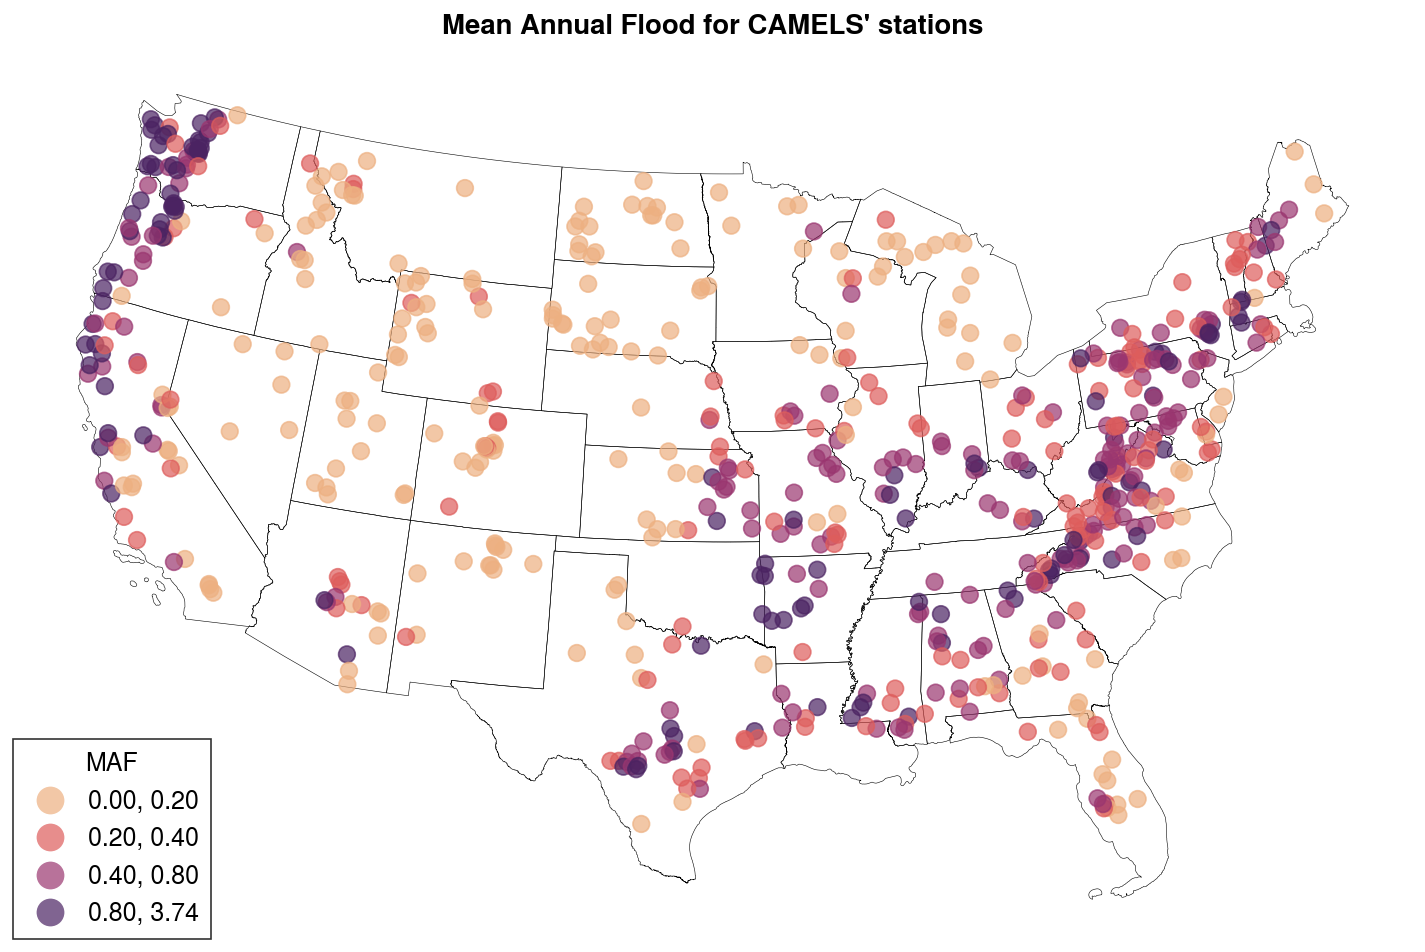

In [72]:
fig, ax = pplt.subplots(refwidth=7, facecolor="w")
ax.format(suptitle="Mean Annual Flood for CAMELS' stations")
conus.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.2)
camels_fm.plot(
    ax=ax,
    column="MAF",
    scheme="User_Defined",
    legend=True,
    cmap="flare",
    alpha=0.7,
    classification_kwds={"bins": [0.2, 0.4, 0.8]},
    legend_kwds={"label": "MAF", "ncols": 1},
)
ax.grid(False)
ax.set_axis_off()

We can also use `explore` function of `geopandas` to plot an interactive map of the results.

In [70]:
def plot_flood_moments(column):
    """Plot flood moments (MAF, CV, CS) from annual peak discharge values."""
    vmin, vmax = camels_fm[column].quantile([0.1, 0.9])
    return camels_fm.explore(
        column=column,
        vmin=vmin,
        vmax=vmax,
        cmap="viridis",
        marker_kwds={"radius": 4},
        style_kwds={"stroke": False},
    )

In [71]:
plot_flood_moments("CV")

In [11]:
plot_flood_moments("CS")